53/53 [==============================] - 0s 4ms/step


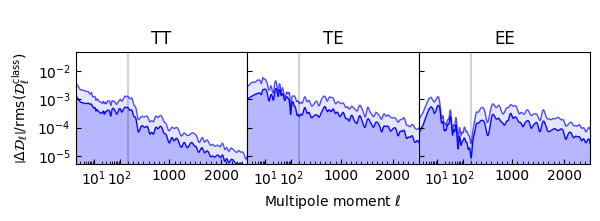

In [3]:
# Import necessary libraries
import tensorflow as tf
import numpy as np
from scipy.interpolate import CubicSpline
import matplotlib.pyplot as plt
import matplotlib
import pickle as pkl
import sys
import os
import PlanckLogLinearScale

# Plotting configuration
n = 0  # Index of test data to use for CMB spectra
color_of_axis_and_text = 'k'  # Color for axes and text
latex = False  # LaTeX configuration flag

# Model loading and test data preparation
name = 'bao_8z_5'
model_directory = '/home/lucajn/connect/trained_models/bao_8z_5'
model = tf.keras.models.load_model(model_directory, compile=False)
with open('/home/lucajn/connect/trained_models/' + name + '/test_data.pkl', 'rb') as f:
    test_data = pkl.load(f)

# Extract test data
model_params = test_data[0]
output_data = test_data[1]
output_info = eval(model.get_raw_info().numpy().decode('utf-8'))
output_predict = model.predict(model_params)

# Prepare predicted and actual data for plotting
out_predict = {}
out_data = {}
for output in output_info['output_Cl']:
    lim0 = output_info['interval']['Cl'][output][0]
    lim1 = output_info['interval']['Cl'][output][1]
    out_data[output] = output_data[n][lim0:lim1]
    out_predict[output] = output_predict[n][lim0:lim1]

# Process derived outputs if available
if 'output_derived' in output_info.keys():
    for output in output_info['output_derived']:
        if output != '100*theta_s':
            idx = output_info['interval']['derived'][output]
            out_data[output] = output_data[n][idx]
            out_predict[output] = output_predict[n][idx]

# Function to calculate root mean square
def rms(x):
    return np.sqrt(np.mean(x**2))

l = np.linspace(2,2500,2499)

# Function to get model error
def get_error(path, spectrum):
    model = tf.keras.models.load_model(path, compile=False)
    with open(path + '/test_data.pkl', 'rb') as f:
        test_data = pkl.load(f)
    
    output_info = eval(model.get_raw_info().numpy().decode('utf-8'))
    ell = output_info['ell']
    model_params = test_data[0]
    Cls_data = test_data[1]
    v = tf.constant(model_params)
    Cls_predict = model(v).numpy()
    
    lim0 = output_info['interval']['Cl'][spectrum][0]
    lim1 = output_info['interval']['Cl'][spectrum][1]
    errors = []
    for j, (cls_d, cls_p) in enumerate(zip(Cls_data, Cls_predict)):
        err = (np.array(cls_d[lim0:lim1]) - np.array(cls_p[lim0:lim1])) / rms(np.array(cls_d[lim0:lim1]))
        errors.append(abs(err))
    errors = np.array(errors).T
    return errors, ell

height = 2.2
width = 6.0874173228
fontsize = 11/1.2*1.5

# Function to get model error
def get_Pk_error(path, spectrum):
    model = tf.keras.models.load_model(path, compile=False)
    with open(path + '/test_data.pkl', 'rb') as f:
        test_data = pkl.load(f)
    
    output_info = eval(model.get_raw_info().numpy().decode('utf-8'))
    k = output_info['k_grid']
    model_params = test_data[0]
    Pks_data = test_data[1]
    v = tf.constant(model_params)
    Pks_predict = model(v).numpy()
    
    lim0 = output_info['interval']['Pk']['pk'][spectrum][0]
    lim1 = output_info['interval']['Pk']['pk'][spectrum][1]
    errors = []
    for j, (pks_d, pks_p) in enumerate(zip(Pks_data, Pks_predict)):
        err = (np.array(pks_d[lim0:lim1]) - np.array(pks_p[lim0:lim1])) / rms(np.array(pks_d[lim0:lim1]))
        errors.append(abs(err))
    errors = np.array(errors).T
    return errors, k

# Error plot configuration
model_paths = [model_directory]
model_names = [name]
percentiles = [0.682, 0.954]
alpha_list = [0.2, 0.1, 0.05]
c_list = ['blue', 'red', 'green']  # Colors for the models

change=200

PlanckLogLinearScale.new_change(change)

# Prepare the error plot
fig, axs = plt.subplots(2, len(output_info['output_Cl']), figsize=(6.0874173228, 2.2),
                        gridspec_kw={'height_ratios': [1, 4]})
fig.subplots_adjust(wspace=0)

# Hide the upper subplots (placeholders)
for i in range(len(output_info['output_Cl'])):
    axs[0, i].axis('off')


for k, spectrum in enumerate(output_info['output_Cl']):
    # Initialize the maximum and minimum y-values
    y_max, y_min = 0, 0
    
    # Loop through each model path
    for i, path in enumerate(model_paths):
        model_name = model_names[i]
        
        # Retrieve errors and reduced light data
        errors, l_red = get_error(path, spectrum)

        # Initialize arrays for error handling
        max_error = []
        err_upper_array = []

        # Calculate percentile errors and find maximum error
        for errs in errors:
            err_upper_list = [np.percentile(errs, 100*p) for p in percentiles]
            err_upper_array.append(err_upper_list)
            max_error.append(max(errs))
        
        # Update the maximum y-value if necessary
        if max(np.array(err_upper_array).flatten()) > y_max:
            y_max = max(np.array(err_upper_array).flatten())
        
        # Loop through percentiles in reverse order to plot error regions
        for j, p in reversed(list(enumerate(sorted(percentiles)))):
            err_u = CubicSpline(l_red, np.array(err_upper_array).T[j])
            
            # Fill between error regions
            fill_between_x = np.array([l[0]]+list(l[:change-1])+[l[change-2]])
            fill_between_y = np.array([0]+list(abs(err_u(l[:change-1])))+[0])
            axs[1,k].fill(fill_between_x, fill_between_y, fc=c_list[i], alpha=alpha_list[j], zorder=i)
            
            # Continue filling after the change point
            fill_between_x = np.array([l[change-2]]+list(l[change-2:])+[l[-1]])
            fill_between_y = np.array([0]+list(abs(err_u(l[change-2:])))+[0])
            axs[1,k].fill(fill_between_x, fill_between_y, fc=c_list[i], alpha=alpha_list[j], zorder=i)

            # Draw a vertical line at the change point
            axs[1,k].axvline(x=change, linestyle="-", color="lightgrey", zorder=-3)
            
            # Plot the error line
            axs[1,k].plot(l, abs(err_u(l)), c=c_list[i], lw=1, zorder=i, alpha=list(reversed(percentiles))[j])

    
    
    # Set up the scales for the x and y axes
    axs[1,k].set_yscale('log')
    axs[1,k].set_xscale('planck')
    
    # Define the x-axis limit
    axs[1,k].set_xlim([2,2500])
    
    # Set x-axis ticks and labels
    xticks = [1e+1, 1e+2, 1e+3, 2e+3]
    xticks_minor = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900,1100,1200,1300,1400,1500,1600,1700,1800,1900,2100,2200,2300,2400,2500] 
    xticklabels=[r'$10^{1}$',r'$10^{2}$','1000','2000']
    axs[1,k].set_xticks(xticks)
    axs[1,k].set_xticks(xticks_minor, minor=True)
    axs[1,k].xaxis.set_ticklabels(xticklabels, color=color_of_axis_and_text)
    
    # Define the y-axis limit and ticks
    axs[1,k].set_ylim([5e-6,5e-2])
    axs[1,k].set_yticks([1e-2,1e-3,1e-4,1e-5])
    
    # Set up the axis labels and title
    if k==1:
        axs[1,k].set_xlabel("Multipole moment $\ell$")
    
    if k == 0:
        # Set custom legend lines depending on the model names count
        custom_lines=[matplotlib.lines.Line2D([],[],c=c_list[2]),
                      matplotlib.lines.Line2D([],[],c=c_list[1]),
                      matplotlib.lines.Line2D([],[],c=c_list[0])]
        if len(model_names) == 2:
            custom_lines = custom_lines[1:]
        elif len(model_names) == 1:
            custom_lines = custom_lines[2:]
        #axs[1,k].legend(custom_lines,model_names,bbox_to_anchor=(2.64,1.5),ncol=len(model_names),fontsize=fontsize/1.5)
        
        # Set y-axis label with LaTeX formatting if enabled
        if latex:
            axs[1,k].set_ylabel(r'$\dfrac{\left\vert \mathcal{D}_{\ell}^{\textsc{connect}}-\mathcal{D}_{\ell}^{\textsc{class}}\right\vert}{{\rm rms}\left(\mathcal{D}_{\ell}^{\textsc{class}}\right)}$')
        else:
            axs[1,k].set_ylabel(r"$\left| \Delta \mathcal{D}_\ell \right| / \mathrm{rms}(\mathcal{D}_\ell^{\mathrm{class}})$")
        
        # Set y-axis labels with color
        yticklabels=[r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$10^{-5}$']
        axs[1,k].yaxis.set_ticklabels(yticklabels, color=color_of_axis_and_text)
    else:
        # Remove y-axis tick labels for other than the first column
        axs[1,k].yaxis.set_ticklabels([])
    
    # Set the plot title and axis parameters
    axs[1,k].set_title(f'{spectrum.upper()}', color=color_of_axis_and_text)
    axs[1,k].tick_params(axis='both', which='both', direction='in')

# Set the scaling factors for the axes position adjustments
factor = 1.09
factor_y = 0.91

# Calculate the offset for the x and y positions
offset = axs[1,0].get_position().x0 * (factor - 1) - 0.03
offset_y = axs[0,0].get_position().y1 * (factor_y - 1) - 0.06

# Adjust positions of all subplots within the figure
for ax in axs.flatten():
    box = ax.get_position()
    box.x0 *= factor
    box.x0 += -offset - 0.005
    box.x1 *= factor
    box.x1 += -offset - 0.005
    box.y0 *= factor_y
    box.y0 += -offset_y
    box.y1 *= factor_y
    box.y1 += -offset_y
    ax.set_position(box)

    # Set the colors for the axis labels
    ax.xaxis.label.set_color(color_of_axis_and_text)  # X-axis label color
    ax.yaxis.label.set_color(color_of_axis_and_text)  # Y-axis label color

    # Set the background color of the axes
    ax.set_facecolor('w')

# Check if the directory exists, if not create it
if not os.path.isdir(model_paths[0]+'/plots'):
    os.mkdir(model_paths[0]+'/plots')

# Display the plot
plt.savefig("CL_errors.pdf", format='pdf', bbox_inches='tight')
plt.show()

[3.37780000e-06 1.35503711e-03 2.70669643e-03 ... 3.37509668e+00
 3.37644834e+00 3.37780000e+00]


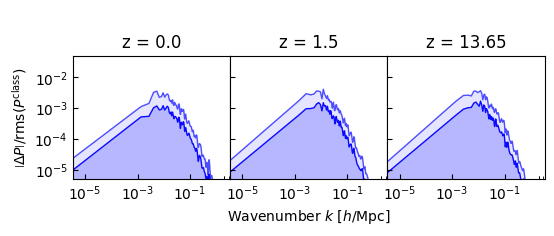

In [11]:
# Error plot configuration
model_paths = [model_directory]
model_names = [name]
percentiles = [0.682, 0.954]
alpha_list = [0.2, 0.1, 0.05]
c_list = ['blue', 'red', 'green']  # Colors for the models
kay = np.linspace(output_info['k_grid'][0], output_info['k_grid'][-1], 2500)
change = 0.001
print(kay)
# Prepare the error plot
fig, axs = plt.subplots(2, len(output_info['interval']['Pk']['pk']), figsize=(6.0874173228, 2.2),
                        gridspec_kw={'height_ratios': [1, 4]})
fig.subplots_adjust(wspace=0)

# Hide the upper subplots (placeholders)
for i in range(len(output_info['interval']['Pk']['pk'])):
    axs[0, i].axis('off')


for k, spectrum in enumerate(output_info['interval']['Pk']['pk']):
    # Initialize the maximum and minimum y-values
    y_max, y_min = 0, 0
    
    # Loop through each model path
    for i, path in enumerate(model_paths):
        model_name = model_names[i]
        
        # Retrieve errors and reduced light data
        errors, k_red = get_Pk_error(path, spectrum)

        # Initialize arrays for error handling
        max_error = []
        err_upper_array = []

        # Calculate percentile errors and find maximum error
        for errs in errors:
            err_upper_list = [np.percentile(errs, 100*p) for p in percentiles]
            err_upper_array.append(err_upper_list)
            max_error.append(max(errs))
        
        # Update the maximum y-value if necessary
        if max(np.array(err_upper_array).flatten()) > y_max:
            y_max = max(np.array(err_upper_array).flatten())
        
        # Loop through percentiles in reverse order to plot error regions
        for j, p in reversed(list(enumerate(sorted(percentiles)))):
            err_u = CubicSpline(k_red, np.array(err_upper_array).T[j])
            
            # Fill between error regions
            fill_between_x = np.array([kay[0]] + list(kay) + [kay[-1]])
            fill_between_y = np.array([0]+list(abs(err_u(kay)))+[0])
            axs[1,k].fill(fill_between_x, fill_between_y, fc=c_list[i], alpha=alpha_list[j], zorder=i)

            # Plot the error line
            axs[1,k].plot(kay, abs(err_u(kay)), c=c_list[i], lw=1, zorder=i, alpha=list(reversed(percentiles))[j])

    
    
    # Set up the scales for the x and y axes
    axs[1,k].set_yscale('log')
    axs[1,k].set_xscale('planck')
    
    # Define the x-axis limit
    axs[1,k].set_xlim([output_info['k_grid'][0],output_info['k_grid'][-1]])
    
    # Set x-axis ticks and labels
    xticks = [1e-5, 1e-3, 1e-1]
    #xticks_minor = [2,3,4,5,6,7,8,9,20,30,40,50,60,70,80,90,200,300,400,500,600,700,800,900,1100,1200,1300,1400,1500,1600,1700,1800,1900,2100,2200,2300,2400,2500] 
    xticklabels=[r'$10^{-5}$',r'$10^{-3}$',r'$10^{-1}$']
    axs[1,k].set_xticks(xticks)
    #axs[1,k].set_xticks(xticks_minor, minor=True)
    axs[1,k].xaxis.set_ticklabels(xticklabels, color=color_of_axis_and_text)
    
    # Define the y-axis limit and ticks
    axs[1,k].set_ylim([5e-6,5e-2])
    axs[1,k].set_yticks([1e-2,1e-3,1e-4,1e-5])
    
    # Set up the axis labels and title
    if k==1:
        axs[1,k].set_xlabel('Wavenumber $k$ [$h/\mathrm{Mpc}$]')
    
    if k == 0:
        # Set custom legend lines depending on the model names count
        custom_lines=[matplotlib.lines.Line2D([],[],c=c_list[2]),
                      matplotlib.lines.Line2D([],[],c=c_list[1]),
                      matplotlib.lines.Line2D([],[],c=c_list[0])]
        if len(model_names) == 2:
            custom_lines = custom_lines[1:]
        elif len(model_names) == 1:
            custom_lines = custom_lines[2:]
        #axs[1,k].legend(custom_lines,model_names,bbox_to_anchor=(2.64,1.5),ncol=len(model_names),fontsize=fontsize/1.5)
        
        # Set y-axis label with LaTeX formatting if enabled
        if latex:
            axs[1,k].set_ylabel(r'$\dfrac{\left\vert \mathcal{D}_{\ell}^{\textsc{connect}}-\mathcal{D}_{\ell}^{\textsc{class}}\right\vert}{{\rm rms}\left(\mathcal{D}_{\ell}^{\textsc{class}}\right)}$')
        else:
            axs[1,k].set_ylabel(r"$\left| \Delta P \right| / \mathrm{rms}(P^{\mathrm{class}})$")
        
        # Set y-axis labels with color
        yticklabels=[r'$10^{-2}$',r'$10^{-3}$',r'$10^{-4}$',r'$10^{-5}$']
        axs[1,k].yaxis.set_ticklabels(yticklabels, color=color_of_axis_and_text)
    else:
        # Remove y-axis tick labels for other than the first column
        axs[1,k].yaxis.set_ticklabels([])
    
    # Set the plot title and axis parameters
    axs[1,k].set_title(f'z = {spectrum.upper()}', color=color_of_axis_and_text)
    axs[1,k].tick_params(axis='both', which='both', direction='in')

# Check if the directory exists, if not create it
if not os.path.isdir(model_paths[0]+'/plots'):
    os.mkdir(model_paths[0]+'/plots')

# Uncomment to save the figure to a file
# plt.savefig(model_paths[0]+f'/plots/error_new2.pdf', facecolor=fig.get_facecolor())

# Display the plot
plt.savefig("Pk_errors.pdf", format='pdf', bbox_inches='tight')
plt.show()
